In [29]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point
from pyproj import CRS


In [2]:
years = list(range(2015,2022+1))
appended_data = pd.DataFrame()

for y in years:
    df_years = pd.read_csv('Data_NO2/'+ str(y) + '.csv')
    # df_years = df_years.drop(columns=['Site no','Grid squaresX', 'Grid squaresY', 'Site Type'])
    df_years = df_years.drop(columns=['Site no', 'Site Type'])
    # df_years = (df_years.set_index(['Location'])
    df_years = (df_years.set_index(['Location','Grid squaresX', 'Grid squaresY'])
            .stack()
            .reset_index(name='Value')
            .rename(columns={'level_3':'Date'}))
    appended_data = appended_data.append(df_years,ignore_index=True)

In [3]:
# Prepare lat/lon in the right coordinate system
from convertbng.util import convert_bng, convert_lonlat
eastings = appended_data["Grid squaresX"]
northings = appended_data["Grid squaresY"]
lon, lat = convert_lonlat(eastings, northings)
appended_data['lat'] = lat
appended_data['lon'] = lon
appended_data = appended_data.drop(columns=['Grid squaresX', 'Grid squaresY'])

In [8]:
# Prepare format for each NO2 measurement location

NO2_locations = appended_data
NO2_locations = NO2_locations.drop(columns=['Date', 'Value'])
NO2_locations = NO2_locations.drop_duplicates(subset=['Location'])
NO2_locations = NO2_locations.set_index('Location').T.to_dict('list')

geometry = [Point(reversed(v)) for _, v in NO2_locations.items()]

NO2_locations_gpd = gpd.GeoDataFrame(geometry=geometry, crs=crs)
NO2_locations_gpd = NO2_locations_gpd.to_crs(epsg=3857)

In [ ]:
# Set bounds
crs = CRS.from_epsg(4326)
min_lat, min_lon, max_lat, max_lon = 51.510000, -0.078000, 51.536322, -0.035000
bounds = gpd.GeoDataFrame(
    geometry=[Point([min_lon, min_lat]), Point([max_lon, max_lat])], crs=crs
)
minx, miny, maxx, maxy = bounds.to_crs(epsg=3857).total_bounds

In [22]:
path_census = (
    "data/Census_Residential_Data_Pack_2011/Local_Authority_Districts/E09000030/"
)
lsoas_link = path_census + "shapefiles/E09000030.shp"
df = gpd.read_file(lsoas_link)
df = lsoas.to_crs(epsg=3857)

In [27]:
def plot(df, metrics, cmaps):
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 20))
    axes = axes if isinstance(axes, np.ndarray) else [axes]
    # cmap = sns.color_palette("crest", as_cmap=True)
    for ax, metric, cmap in zip(axes, metrics, cmaps):
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        # title = 'Multiple deprivation index per LSOA in Tower Hamlets'
        ax.set_title(metric, fontdict={"fontsize": "15", "fontweight": "3"})
        ax.axis("off")

        df.plot(ax=ax, alpha=0.8, edgecolor="k", column=metric, cmap=cmap)
        NO2_locations_gpd.plot(
            ax=ax,
            markersize=200,
            color="red",
            marker="*",
            label="modal filters",
            zorder=3,
        )
        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(vmin=df[metric].min(), vmax=df[metric].max())
        )  # empty array for the data range
        cbar = fig.colorbar(sm, shrink=0.4, ax=ax)
        cx.add_basemap(ax)
        ax.legend()
    fig.tight_layout()
    return fig

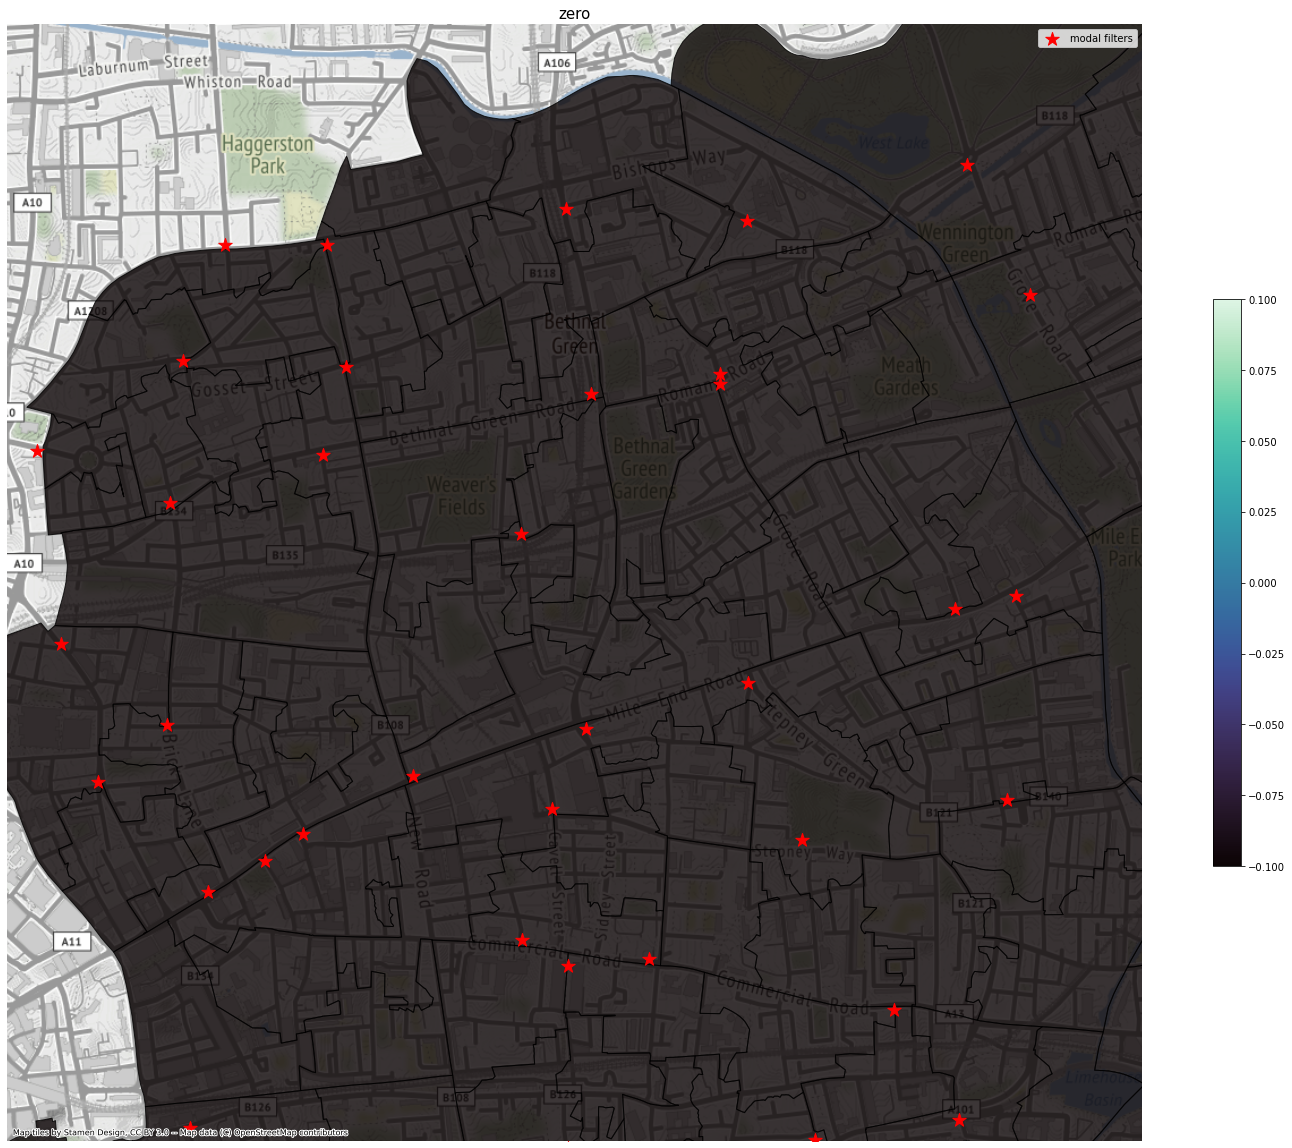

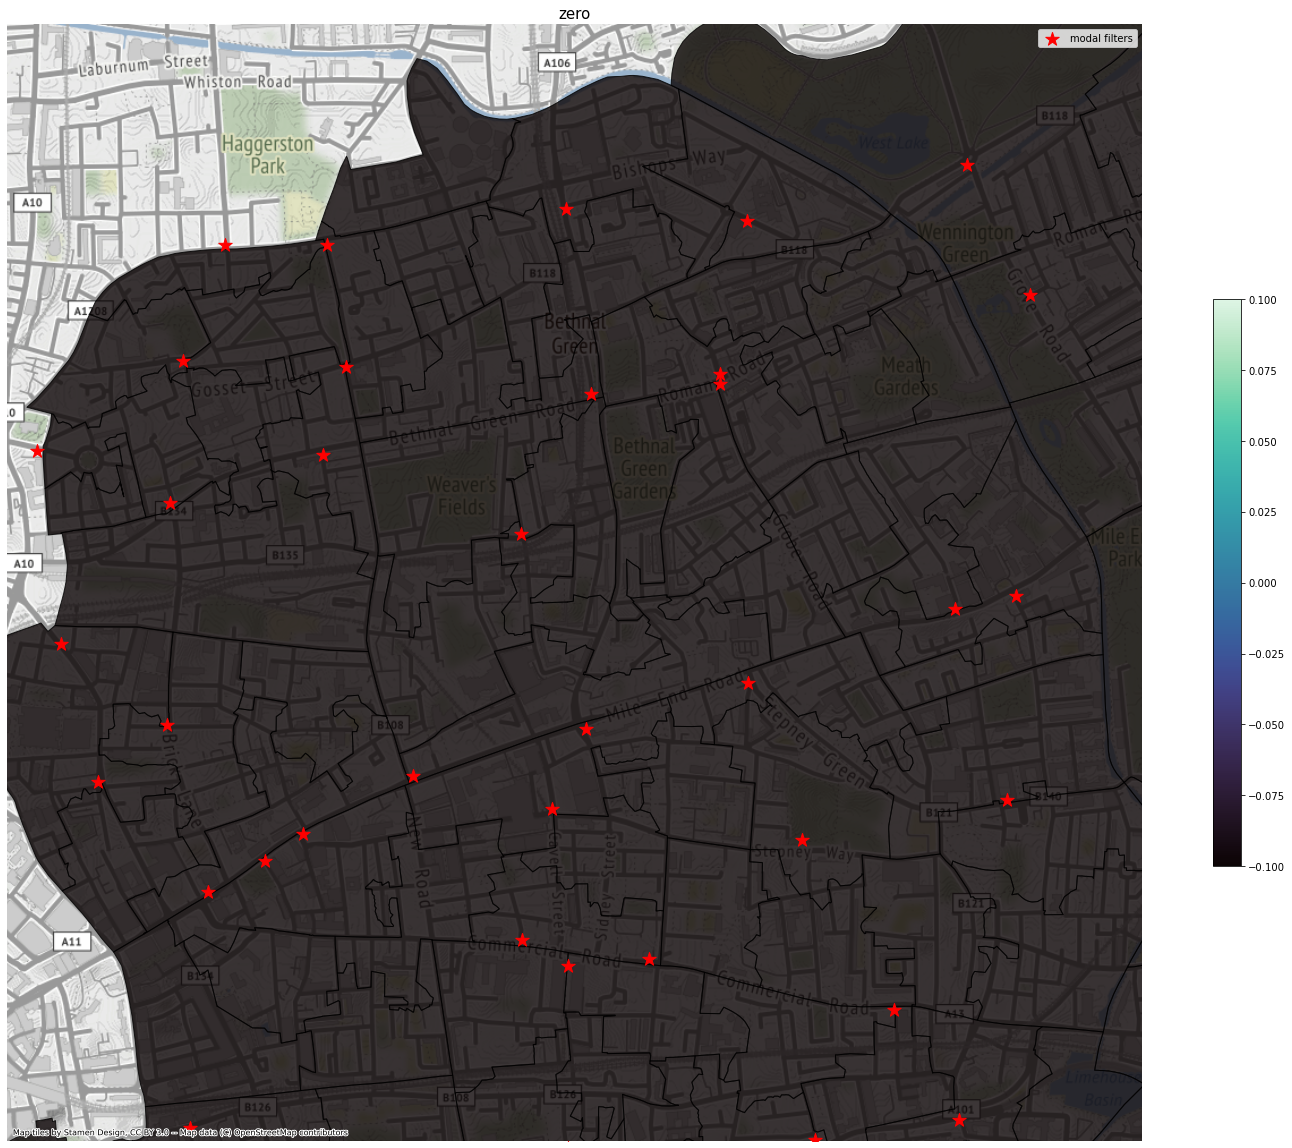

In [30]:
df['zero'] = 0
metrics = ['zero']
cmaps = [
    sns.color_palette("mako", as_cmap=True),
    sns.color_palette("mako_r", as_cmap=True),
]

plot(df, metrics, cmaps)

In [31]:
df

,lsoa11cd,geometry,zero
0,E01004197,"POLYGON ((-6428.222 6715984.816, -6433.607 671...",0
1,E01004198,"POLYGON ((-5938.332 6715904.325, -5933.230 671...",0
2,E01004199,"POLYGON ((-6635.654 6715897.502, -6646.141 671...",0
3,E01004200,"POLYGON ((-6854.429 6715557.952, -6868.673 671...",0
4,E01004201,"POLYGON ((-5503.415 6716258.593, -5502.727 671...",0
...,...,...,...
139,E01032783,"POLYGON ((-2685.847 6708276.166, -2688.977 670...",0
140,E01032784,"POLYGON ((-3189.372 6715850.628, -3188.390 671...",0
141,E01032785,"POLYGON ((-4852.733 6715052.469, -4855.763 671...",0
142,E01032786,"POLYGON ((-4899.321 6715874.446, -4894.335 671...",0


In [19]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.
